# Figure 3a-e

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from requirements import *
from segger.data.parquet._utils import (
    read_parquet_region,
    load_settings,
)
from sg_utils.pl.plot_segmentation import *
from colorspace import qualitative_hcl

In [4]:
# Segmentation columns to plot
uid_map = {
    '3Q6EISGCD9': 'One-Hot Encoding',
    'HDE46PBXJB': 'HLC Atlas Abundance',
}
segmentations = [
    ('cellpose_cell_id', 'CellPose'),
    ('10x_cell_id', '10X Cell'),
    ('10x_nucleus_id', '10X Nucleus'),
]
segmentations += [(f'baysor_cell_id_c={c}', f'Baysor, {c}') for c in [0.5, 0.9]]
segmentations += [(f'segger_cell_id_{k}', f'Segger, {v}') for k, v in uid_map.items()]

## Subset data to region

In [5]:
# Region to plot
xmin = 845 #803.6937
xmax = 1195 #1203.6937
ymin = 12100 #12004.2764
ymax = 12450 #12604.2764
region = shapely.box(xmin, ymin, xmax, ymax)

In [6]:
# Read and filter transcripts
transcripts_filepath = data_dir / 'labeled_transcripts.parquet'
xe_settings = load_settings('xenium')
extra_columns = ['cellpose_cell_type'] + [s[0] for s in segmentations]
transcripts = read_parquet_region(
    transcripts_filepath,
    *xe_settings.transcripts.xy,
    bounds=region,
    extra_columns=extra_columns,
)

# Map epithelial label to transcripts
is_epithelial = transcripts['cellpose_cell_type'].eq('Epithelial/Cancer')
transcripts['is_epithelial'] = is_epithelial

In [7]:
# Read and filter boundary polygons
boundaries_filepath = data_dir / 'cellpose_mask_polygons.parquet'
boundaries = gpd.read_parquet(boundaries_filepath)
mask = boundaries.within(region.buffer(20))
boundaries = boundaries[mask]

# Filter boundaries to epithelial
gb = transcripts.groupby('cellpose_cell_id')
mask = gb['is_epithelial'].mean().gt(0.5)
mask &= gb.size().gt(50)
mask = boundaries.index.isin(mask.index[mask])
boundaries = boundaries[mask]

In [8]:
# Read and filter membrane/DAPI image
image_filepath = data_dir / 'segmentation_image.npy'
image = np.load(image_filepath)
mpp = 0.2125 * 2
image = image[
    int(ymin / mpp): int(ymax / mpp),
    int(xmin / mpp): int(xmax / mpp),
]
mem = np.tile(image[:, :, 1, np.newaxis], (1, 1, 3)) * np.array([0, 1, 1])
nuc = np.tile(image[:, :, 0, np.newaxis], (1, 1, 3)) * np.array([1, 0, 0])
image = (nuc + mem).astype('uint8')

## Plot segmentation masks

In [9]:
# Plot IF images
fig, ax = plt.subplots(1,1, figsize=(2.5, 2.5))
ax.pcolormesh(
    np.linspace(xmin, xmax, image.shape[1]),
    np.linspace(ymin, ymax, image.shape[0]),
    image,
    rasterized=True,
)
format_ax(ax, (xmin, xmax), (ymin, ymax))
fig.savefig(media_dir / f'figure_3a.svg')
plt.close()

In [10]:
# Plot segmentation overlay
fig, ax = plt.subplots(1,1, figsize=(2.5, 2.5))
plot_segmentation_boundaries(boundaries, ax)
ax.set_facecolor([0]*4)
format_ax(ax, (xmin, xmax), (ymin, ymax))
fig.savefig(media_dir / f'segmentation_overlay.svg')
plt.close()

In [16]:
sns.color_palette([named_colors[k] for k in ['10X', 'Segger Embedding', 'Segger', '10X Nucleus', 'Baysor']])

[(0.4117647058823529, 0.1607843137254902, 0.7725490196078432),
 (0.6980392156862745, 0.21568627450980393, 0.23137254901960785),
 (0.7294117647058823, 0.3058823529411765, 0.0),
 (0.9333333333333333, 0.3254901960784314, 0.596078431372549),
 (0.06666666666666667, 0.5725490196078431, 0.9137254901960784)]

In [11]:
# Columns to show for callouts
seg_cols = [
    '10x_cell_id',
    '10x_nucleus_id',
    'baysor_cell_id_c=0.5',
    'segger_cell_id_HDE46PBXJB',
]

# Plot segmentation callouts
for panel, seg_col in zip(['b', 'c', 'd', 'e'], seg_cols):
    
    fig, ax = plt.subplots(1,1, figsize=(2.5, 2.5))
    pos_col = 'is_epithelial'
    gb = transcripts.groupby(seg_col)
    tx_mask = gb[pos_col].mean().gt(0.5) & gb.size().gt(50)
    tx_mask = transcripts[seg_col].map(tx_mask).fillna(False)
    
    plot_segmentation(
        transcripts[tx_mask],
        x='x_location',
        y='y_location',
        seg_col=seg_col,
        pos_col=pos_col,
        ax=ax,
        cell_id_colors=named_colors['Categorical Dark'],
        xlim=(xmin, xmax),
        ylim=(ymin, ymax),
        transcript_styles=dict(s=0.3, rasterized=True),
        negative_styles=dict(s=0.6, alpha=0.5, c='red', rasterized=True),
    )
    fig.savefig(media_dir / f'figure_3{panel}.svg', dpi=800)
    plt.close()

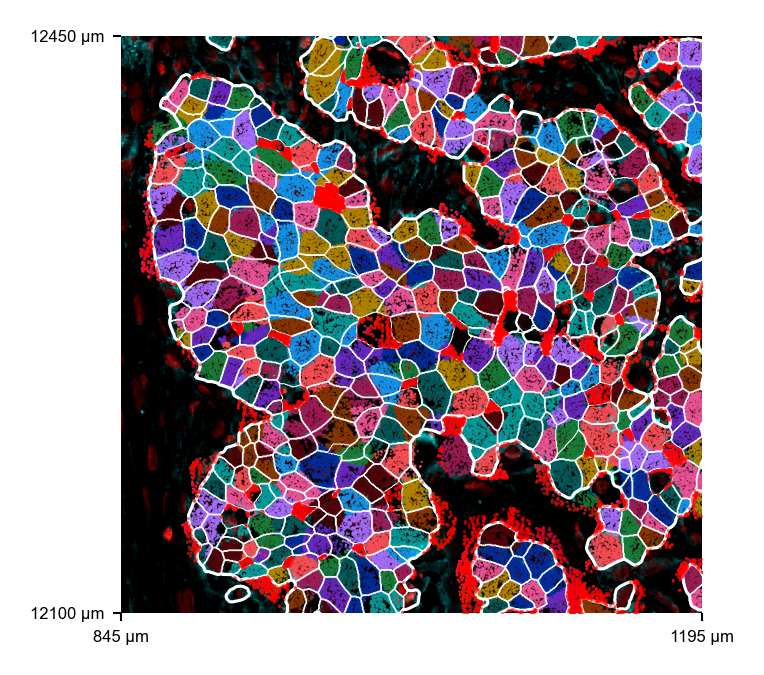

In [12]:
# Plot segmentation callouts
seg_col = '10x_cell_id'
    
fig, ax = plt.subplots(1,1, figsize=(2.5, 2.5))
pos_col = 'is_epithelial'
gb = transcripts.groupby(seg_col)
tx_mask = gb[pos_col].mean().gt(0.5) & gb.size().gt(50)
tx_mask = transcripts[seg_col].map(tx_mask).fillna(False)

plot_segmentation(
    transcripts[tx_mask],
    x='x_location',
    y='y_location',
    seg_col=seg_col,
    pos_col=pos_col,
    image=image,
    boundaries=boundaries,
    ax=ax,
    cell_id_colors=named_colors['Categorical Dark'],
    xlim=(xmin, xmax),
    ylim=(ymin, ymax),
    transcript_styles=dict(s=0.3, rasterized=True),
    negative_styles=dict(s=0.6, alpha=0.5, c='red', rasterized=True),
)